<a href="https://colab.research.google.com/github/nagasora/MITSUI-CO.-Commodity-Prediction-Metric/blob/main/EDA%2C%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import json
f = open("/content/drive/MyDrive/kaggle notebook/kaggle.json")
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']


In [3]:
!pip install kaggle


In [4]:
#APIコマンドを入力
!kaggle competitions download -c mitsui-commodity-prediction-challenge

  0% 0.00/9.94M [00:00<?, ?B/s]
100% 9.94M/9.94M [00:00<00:00, 706MB/s]


In [5]:
import os
import zipfile

# Specify the path to the zip file in Google Drive
zip_file_path = "/content/mitsui-commodity-prediction-challenge.zip"

# Specify the destination directory (same as the zip file directory)
destination_directory = os.path.dirname(zip_file_path)

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

print(f"File unzipped to: {destination_directory}")

File unzipped to: /content


#data loading and first exploration


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette('husl')

train = pd.read_csv('/content/train.csv')
train_labels = pd.read_csv('/content/train_labels.csv')
target_pairs = pd.read_csv('/content/target_pairs.csv')

print('training data:', train.shape)
print('train label:', train_labels.shape)
print('target_pairs:', target_pairs.shape)

training data: (1917, 558)
train label: (1917, 425)
target_pairs: (424, 3)


# feature categories anlysis


In [7]:
def categorize_columns(columns):
  categories = {
      'LME': [col for col in columns if col.startswith('LME_')],
      'JPX': [col for col in columns if col.startswith('JPX_')],
      'US': [col for col in columns if col.startswith('US_Stock_')],
      'FX': [col for col in columns if col.startswith('FX_')],
      'Other': [col for col in columns if not any(col.startswith(prefix) for prefix in ['LME_', 'JPX_', 'US_Stock_', 'FX_'])]
  }
  return categories

feature_categories = categorize_columns(train.columns)

for category, columns in feature_categories.items():
  print(f"{category}: {len(columns)} columns")
  if len(columns) <= 10:
    print(f" columns: {columns}")

  else:
    print(f"  Sample: {columns[:5]} ... {columns[-2:]}")
  print()

LME: 4 columns
 columns: ['LME_AH_Close', 'LME_CA_Close', 'LME_PB_Close', 'LME_ZS_Close']

JPX: 40 columns
  Sample: ['JPX_Gold_Mini_Futures_Open', 'JPX_Gold_Rolling-Spot_Futures_Open', 'JPX_Gold_Standard_Futures_Open', 'JPX_Platinum_Mini_Futures_Open', 'JPX_Platinum_Standard_Futures_Open'] ... ['JPX_Platinum_Standard_Futures_open_interest', 'JPX_RSS3_Rubber_Futures_open_interest']

US: 475 columns
  Sample: ['US_Stock_ACWI_adj_open', 'US_Stock_AEM_adj_open', 'US_Stock_AG_adj_open', 'US_Stock_AGG_adj_open', 'US_Stock_ALB_adj_open'] ... ['US_Stock_XOM_adj_volume', 'US_Stock_YINN_adj_volume']

FX: 38 columns
  Sample: ['FX_AUDJPY', 'FX_AUDUSD', 'FX_CADJPY', 'FX_CHFJPY', 'FX_EURAUD'] ... ['FX_NOKJPY', 'FX_ZARGBP']

Other: 1 columns
 columns: ['date_id']



# missing values anlysis

missing values analysis:
LME
columns: 4
average missing %: 2.61%
  Range: 2.61% - 2.61%

JPX
columns: 40
average missing %: 6.00%
  Range: 6.00% - 6.00%

US
columns: 475
average missing %: 4.22%
  Range: 3.34% - 87.06%

FX
columns: 38
average missing %: 0.00%
  Range: 0.00% - 0.00%

Other
columns: 1
average missing %: 0.00%
  Range: 0.00% - 0.00%



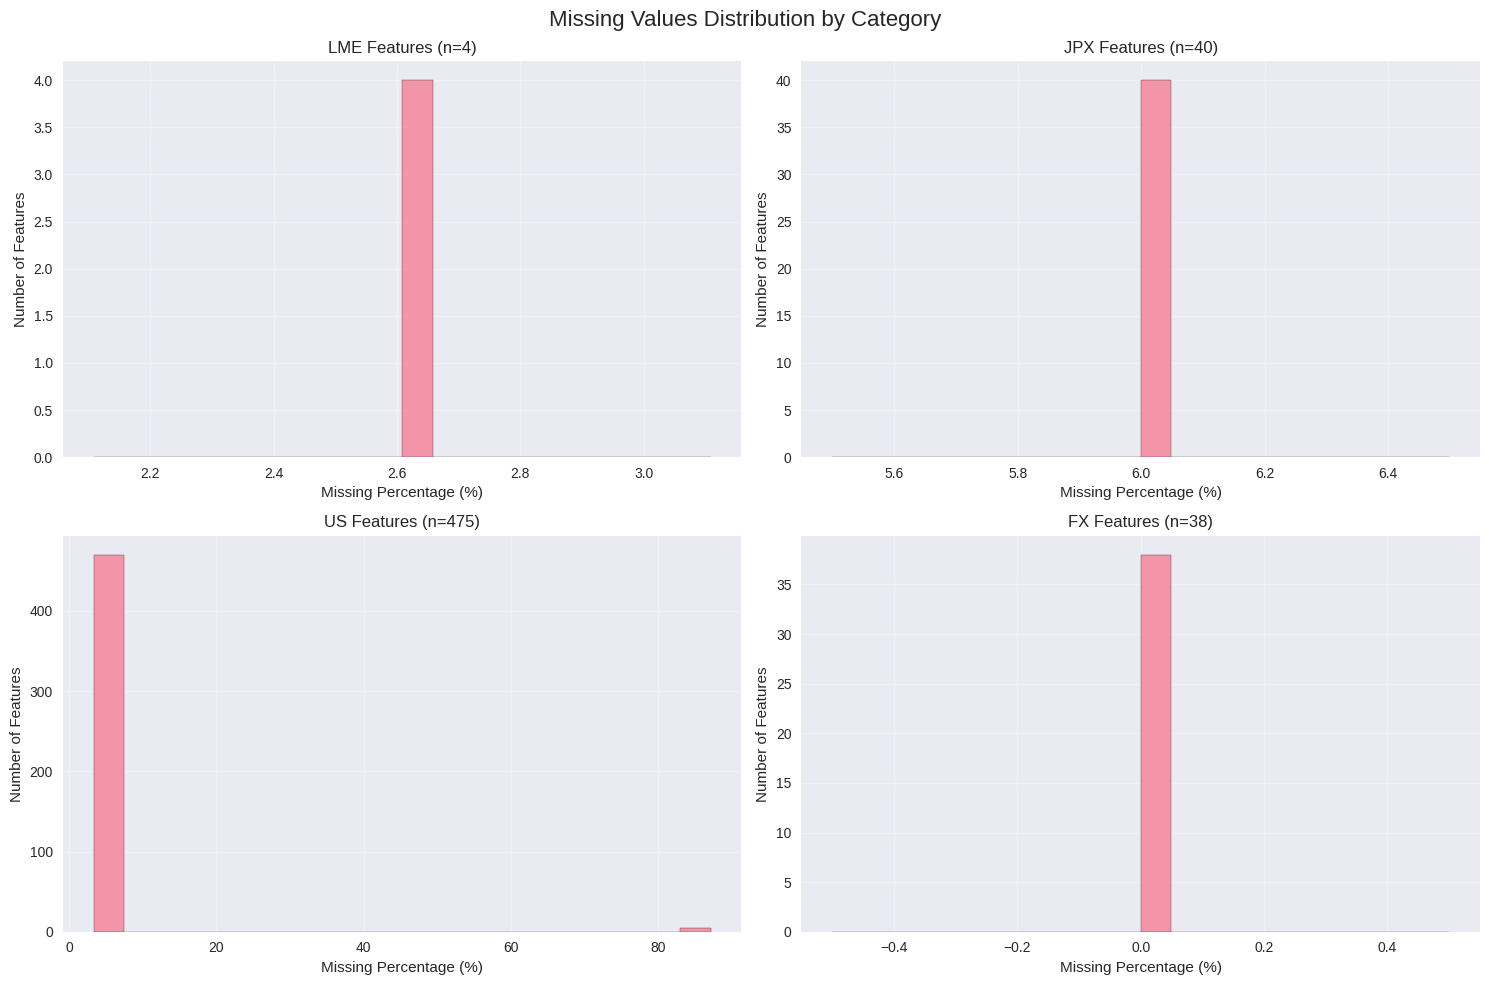

In [8]:
def missing_values_analysis(df, categories):
  missing_stats = {}

  for category, columns in categories.items():
    if not categories:
      continue

    category_missing = df[columns].isnull().sum()
    missing_pct = (category_missing / len(df)* 100 ).round(2)
    missing_stats[category] = {
        'columns:' : len(columns),
        'total_missing': category_missing.sum(),
        'avg_missing_pct': missing_pct.mean(),
        'max_missing_pct': missing_pct.max(),
        'min_missing_pct': missing_pct.min()
    }

  return missing_stats

missing_analysis = missing_values_analysis(train, feature_categories)
print('missing values analysis:')
for category, stats in missing_analysis.items():
  print(f"{category}")
  print(f"columns: {stats['columns:']}")
  print(f"average missing %: {stats['avg_missing_pct']:.2f}%")
  print(f"  Range: {stats['min_missing_pct']:.2f}% - {stats['max_missing_pct']:.2f}%")
  print()

#visualizing missing values
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Missing Values Distribution by Category', fontsize=16)

categories_to_plot = ['LME', 'JPX', 'US', 'FX']
for idx, category in enumerate(categories_to_plot):
    ax = axes[idx // 2, idx % 2]

    if feature_categories[category]:
        missing_pct = train[feature_categories[category]].isnull().sum() / len(train) * 100
        ax.hist(missing_pct, bins=20, alpha=0.7, edgecolor='black')
        ax.set_title(f'{category} Features (n={len(feature_categories[category])})')
        ax.set_xlabel('Missing Percentage (%)')
        ax.set_ylabel('Number of Features')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# target variable analysis


targets on periods
 Lag 1: 106 targets
 Lag 2: 106 targets
 Lag 3: 106 targets
 Lag 4: 106 targets

Total Targets: 424
target_types
Single target instruments: {4}
Pair target instruments: {420}


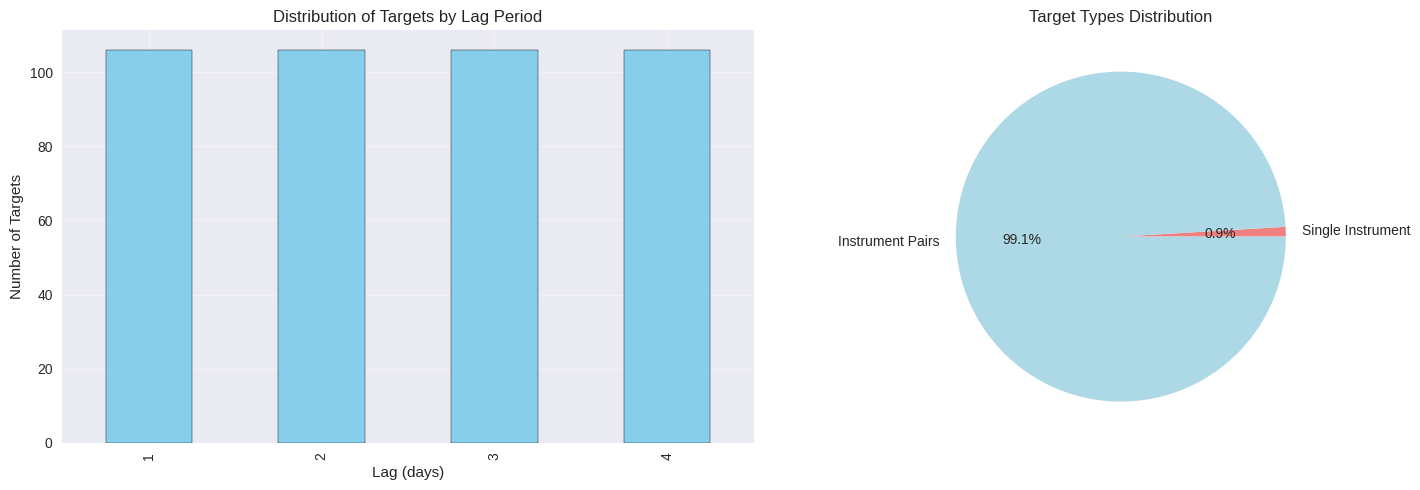

In [9]:
#count by lag
lag_counts = target_pairs['lag'].value_counts().sort_index()
print('targets on periods')
for lag, count in lag_counts.items():
  print(f" Lag {lag}: {count} targets")

print(f"\nTotal Targets: {len(target_pairs)}")

def categorize_targets(target_pairs):
  single_targets = []
  pair_targets = []

  for _, row in target_pairs.iterrows():
    pair = row['pair']
    if '-' in pair:
      pair_targets.append(row)
    else:
      single_targets.append(row)

  return single_targets, pair_targets

single_targets, pair_targets = categorize_targets(target_pairs)

print(f"target_types")
print(f"Single target instruments:", {len(single_targets)})
print(f"Pair target instruments:", {len(pair_targets)})

# Visualize target types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Lag distribution
lag_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Targets by Lag Period')
ax1.set_xlabel('Lag (days)')
ax1.set_ylabel('Number of Targets')
ax1.grid(True, alpha=0.3)

# Target types
target_types = ['Single Instrument', 'Instrument Pairs']
type_counts = [len(single_targets), len(pair_targets)]
ax2.pie(type_counts, labels=target_types, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
ax2.set_title('Target Types Distribution')

plt.tight_layout()
plt.show()






# target values distribution analysis

Target values statistics
<bound method NDFrame.describe of       target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0     0.005948 -0.002851 -0.004675 -0.000639       NaN       NaN -0.006729   
1     0.005783 -0.024118 -0.007052 -0.018955 -0.031852 -0.019452  0.003002   
2     0.001048  0.023836 -0.008934 -0.022060       NaN       NaN  0.037449   
3     0.001700 -0.024618  0.011943  0.004778       NaN       NaN -0.012519   
4    -0.003272  0.005234  0.006856  0.013312  0.023953  0.010681 -0.011649   
...        ...       ...       ...       ...       ...       ...       ...   
1912 -0.012596  0.009309  0.007947  0.006477 -0.026216 -0.029487 -0.003287   
1913 -0.000736 -0.001292 -0.005137 -0.007961 -0.008494 -0.011547  0.004263   
1914 -0.002294  0.012898  0.009978  0.001567  0.002596 -0.007373  0.007554   
1915       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1916       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

    

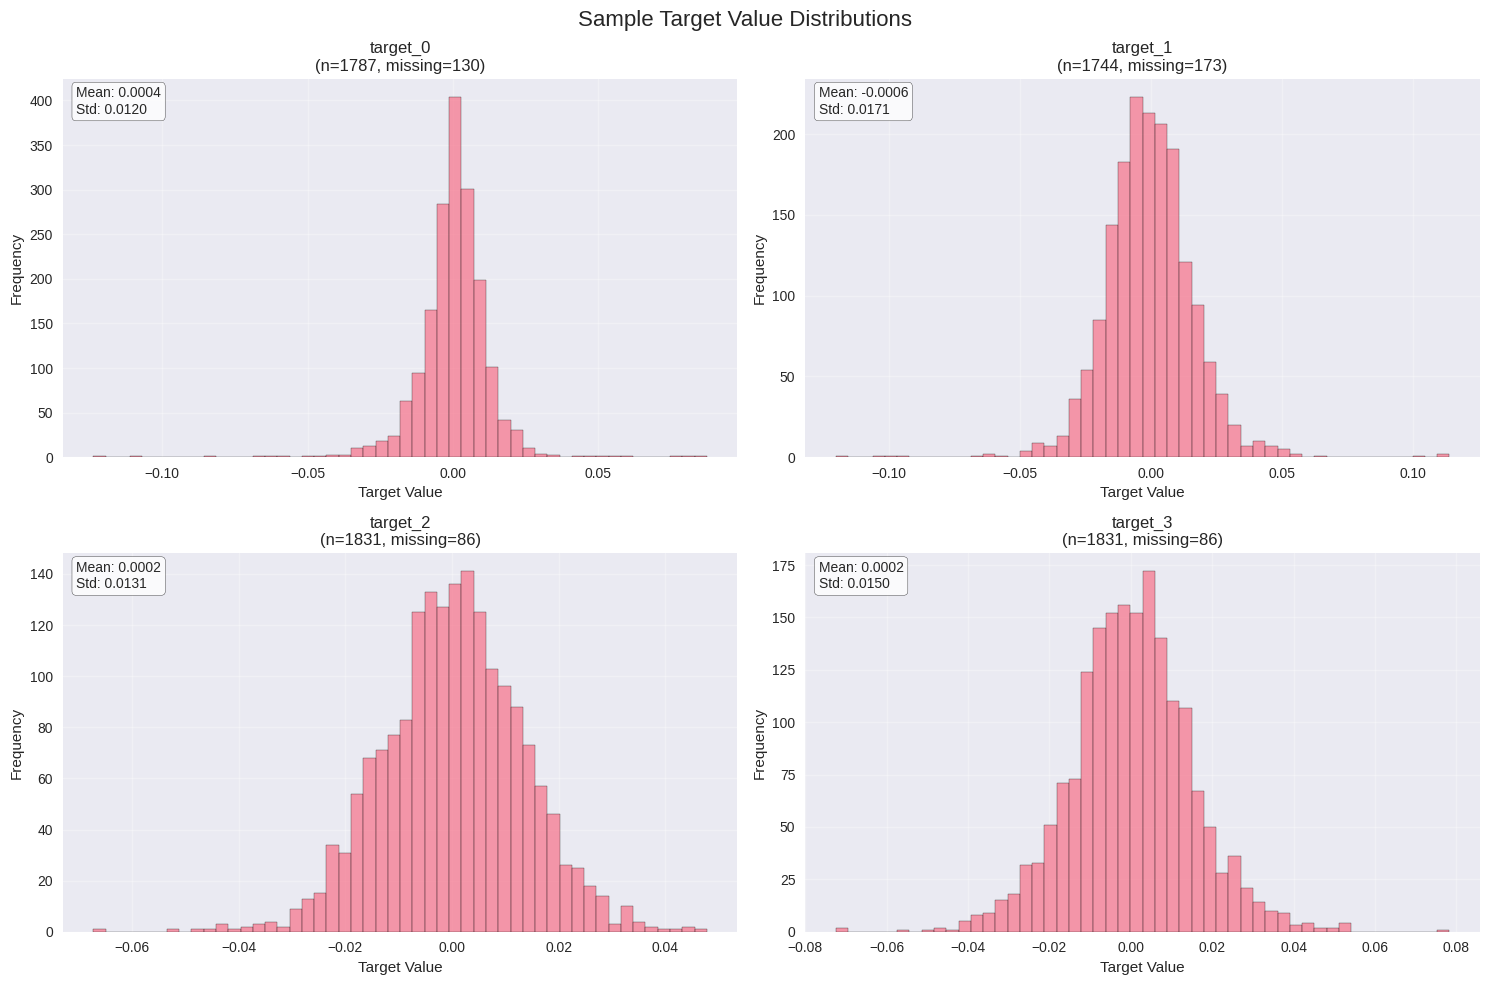

In [12]:
target_columns = [col for col in train_labels.columns if col.startswith('target')]

print('Target values statistics')

target_stats = train_labels[target_columns].describe
print(target_stats)

target_missing = train_labels[target_columns].isnull().sum()
print('missing values in target columns')
print(f"total missing: {target_missing.sum()}")
print(f'target with missing values: {(target_missing > 0).sum()}')
print(f"average missing per targets: {target_missing.mean():.2f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sample_targets = target_columns[:4]
for idx, target in enumerate(sample_targets):
  ax = axes[idx // 2, idx % 2]
# Remove null values for plotting
  target_values = train_labels[target].dropna()

  ax.hist(target_values, bins=50, alpha=0.7, edgecolor='black')
  ax.set_title(f'{target}\n(n={len(target_values)}, missing={train_labels[target].isnull().sum()})')
  ax.set_xlabel('Target Value')
  ax.set_ylabel('Frequency')
  ax.grid(True, alpha=0.3)

  # Add statistics text
  stats_text = f'Mean: {target_values.mean():.4f}\nStd: {target_values.std():.4f}'
  ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle('Sample Target Value Distributions', fontsize=16)
plt.tight_layout()
plt.show()

# time series anlysis

time series anlysis
time range: 0 to 1916
total time periods: 7
date gaps: min 1, max 1, unique [1]


IndexError: index 2 is out of bounds for axis 0 with size 2

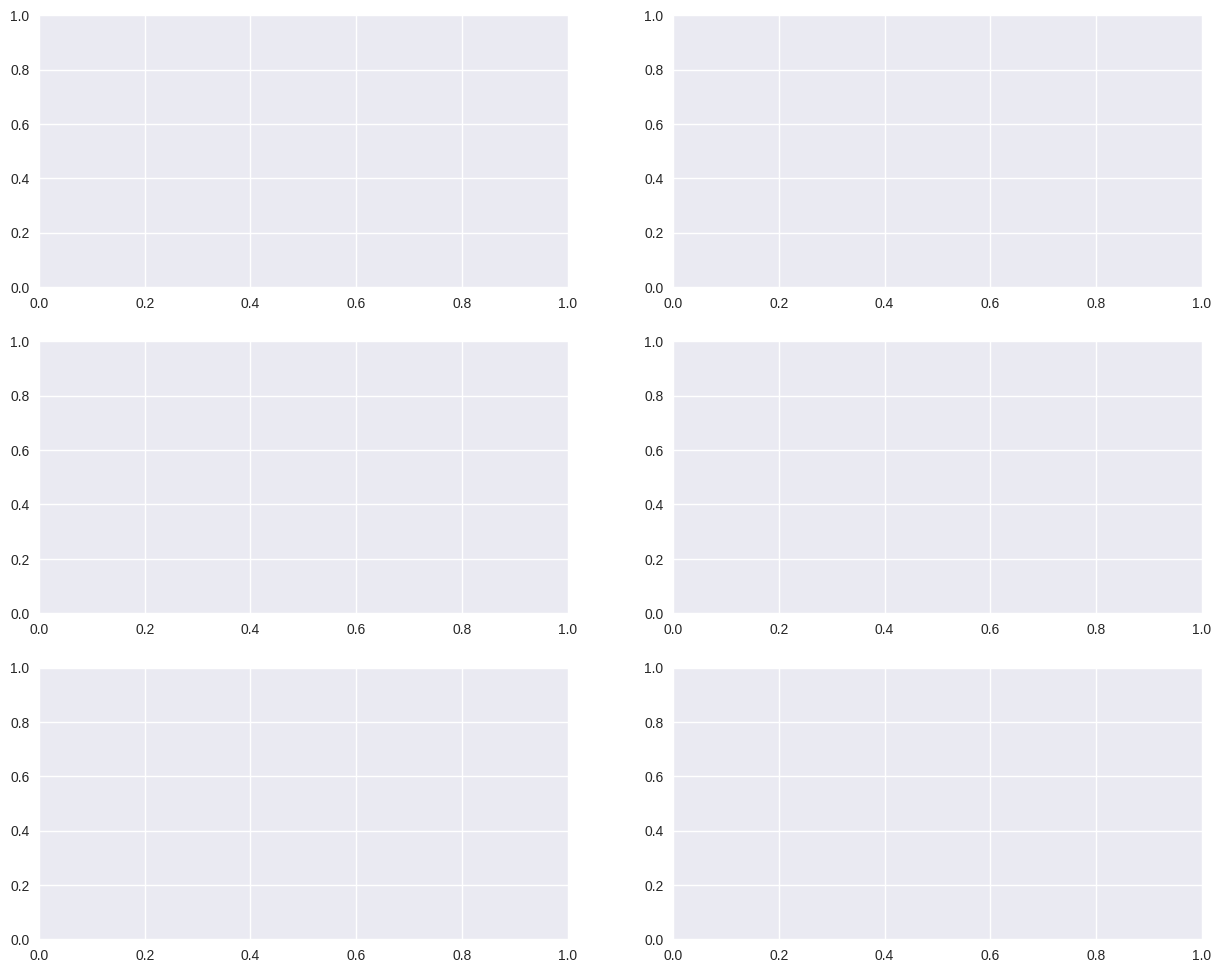

In [17]:
print("time series anlysis")
print(f"time range: {train['date_id'].min()} to {train['date_id'].max()}")
print(f"total time periods: {len('date_od')}")

date_diff = np.diff(train['date_id'].sort_values())
print(f"date gaps: min {date_diff.min()}, max {date_diff.max()}, unique {np.unique(date_diff)}")

fig, aves = plt.subplots(3,2,  figsize=(15, 12))

# Sample different categories of features
sample_features = [
    'LME_AH_Close',  # Metal
    'JPX_Gold_Standard_Futures_Close',  # Futures
    'US_Stock_GLD_adj_close',  # US Stock (Gold ETF)
    'FX_EURUSD',  # FX
    'target_0',  # Target
    'target_1'   # Target
]

for idx, feature in enumerate(sample_features):
    ax = axes[idx // 2, idx % 2]

    if feature.startswith('target_'):
        data = train_labels
    else:
        data = train

    # Plot non-null values
    mask = data[feature].notna()
    x_vals = data.loc[mask, 'date_id']
    y_vals = data.loc[mask, feature]

    ax.plot(x_vals, y_vals, linewidth=1, alpha=0.8)
    ax.set_title(f'{feature}')
    ax.set_xlabel('Date ID')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

    # Add missing data info
    missing_pct = (data[feature].isnull().sum() / len(data) * 100)
    ax.text(0.02, 0.98, f'Missing: {missing_pct:.1f}%',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle('Sample Time Series Plots', fontsize=16)
plt.tight_layout()
plt.show()